In [134]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import itertools
from scipy import stats
import nibabel as nib
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import matplotlib.colors as colors
import seaborn as sns

In [125]:
r=20

In [68]:
fig_dir = '../../paper/figs/source/best_locs'
freq_fig_dir = '../../paper/figs/source/freq'
ram_data_dir = '../../data/ram'

In [4]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [5]:
ram_freq_dir = os.path.join(ram_data_dir, 'freq')
pyfr_freq_dir = os.path.join(pyfr_data_dir, 'freq')

In [6]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

In [7]:

freqs = ['delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
latex_freqs = ["$\delta$", r'$\theta$', r'$\alpha$', r'$\beta$', "$\gamma_L$", "$\gamma_H$", 'broadband']

In [81]:
freqs = ['delta', 'theta']

In [124]:

most_infos = []

for e, freq in enumerate(freqs):
    ram_freq_df = pd.DataFrame()
    pyfr_freq_df = pd.DataFrame()

    freq_dfs = [ram_freq_df, pyfr_freq_df]

    ram_info = np.array([])
    pyfr_info = np.array([])
    most_infos_freq = [ram_info, pyfr_info]
    
    for d, ds in enumerate(['ram', 'pyfr']):
        
        ds_dir = ds + '_freq_dir'
        temp_pd = pd.read_csv(os.path.join(eval(ds_dir), freq + '.csv'), index_col=0)
        temp_pd.name = ds
        temp_pd['across'] = plot.r2z(temp_pd['across'])
        temp_pd['within'] = plot.r2z(temp_pd['within'])
        temp_pd_mean = temp_pd.groupby('Subject')['across','within'].mean()
        
        corr_by_subject = np.array([])
        
        R_locs = []
        subj_by_subject = np.array([])
        for i, s in enumerate(temp_pd_mean.index):


            sub_locs = plot.compile_df_locs(temp_pd['R'][temp_pd['Subject'] == s])

            if R_locs == []:
                R_locs = sub_locs 
            else:

                R_locs = np.vstack((R_locs, sub_locs))

            sub_corr = np.atleast_2d(temp_pd_mean['across'][i])

            corr_by_subject = np.append(corr_by_subject, np.array([temp_pd_mean['across'][i]]* np.shape(sub_locs)[0]))

            subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(sub_locs)[0]))



        freq_dfs[d]['Correlation'] = plot.z2r(corr_by_subject)
        freq_dfs[d]['Subject'] = subj_by_subject
        freq_dfs[d]['R'] = None
        
        R_locs_str = []
        for i in range(freq_dfs[d].shape[0]):
            R = str(R_locs[i])
            if R_locs_str == []:
                R_locs_str = R
            else:

                R_locs_str = np.vstack((R_locs_str, R))

        freq_dfs[d]['R'] = R_locs_str

    
        most_infos_freq[d] = plot.most_informative_locs(freq_dfs[d], vox_size=4, width=r)
        
    most_infos.append(np.array(most_infos_freq))

In [132]:
## for fsl view overlay
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values
sub_nii.save(os.path.join(fig_dir, '4mm_brain.nii'))

In [139]:
freqs

['delta', 'theta']

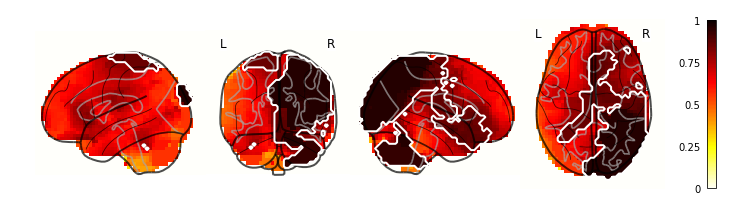

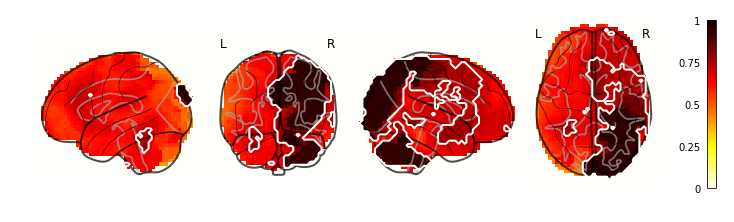

In [137]:
for e, freq in enumerate(freqs):
    
    best_locs_mask = pd.DataFrame()
    best_locs_mask['RAM'] = most_infos[e][0]
    best_locs_mask['PyFR'] = most_infos[e][1]
    
    pyfr_best = best_locs_mask['PyFR']> np.percentile(best_locs_mask['PyFR'].values, 90)

    ram_best = best_locs_mask['RAM']> np.percentile(best_locs_mask['RAM'].values, 90)
    
    intersect = pyfr_best.astype('int64') + ram_best.astype('int64')

    masked_best_locs = intersect>1
    bo_nii_best = se.Brain(data=np.atleast_2d(masked_best_locs ), locs=sub_locs)

    nii_bo_best = se.helpers._brain_to_nifti(bo_nii_best, sub_nii)

    mask = nib.Nifti1Image(header=nii_bo_best.header, dataobj=np.squeeze(nii_bo_best.get_data()), affine=nii_bo_best.affine)
    
    #nii_bo_best.save(os.path.join(fig_dir, freq + '_90th.nii'))
    
    bo_nii = se.Brain(data=np.atleast_2d(best_locs_mask['RAM'].values), locs=sub_locs)
    nii_bo = se.helpers._brain_to_nifti(bo_nii, sub_nii)
    h = ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=1, vmin=0, display_mode='lyrz')
    h.add_contours(mask, levels=[.5], colors='w', linewidths=2)

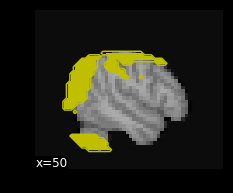

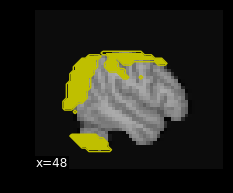

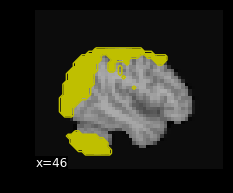

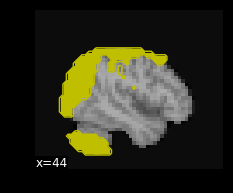

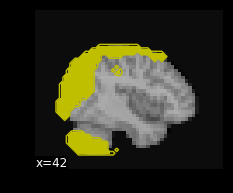

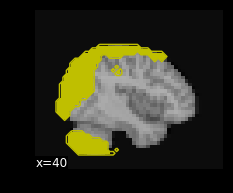

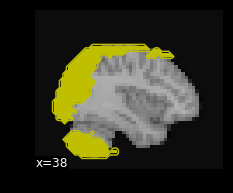

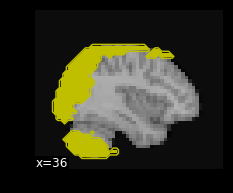

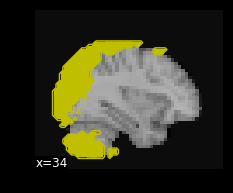

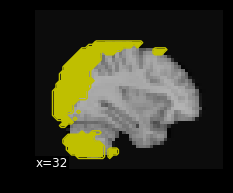

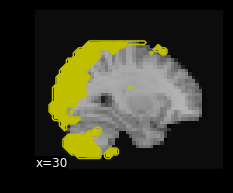

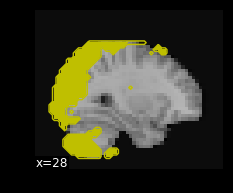

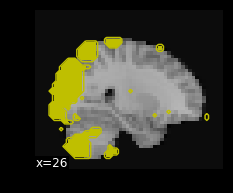

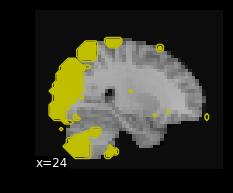

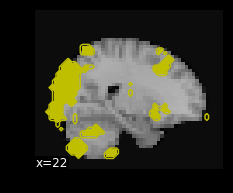

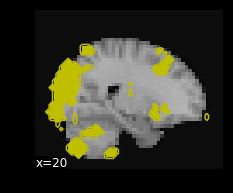

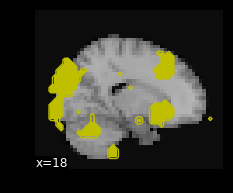

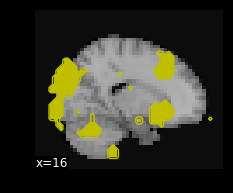

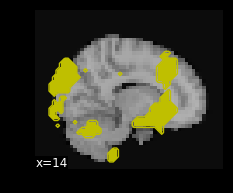

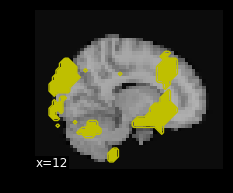

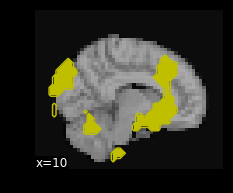

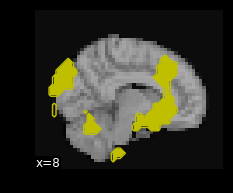

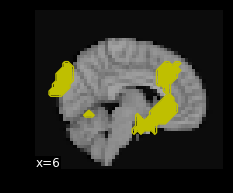

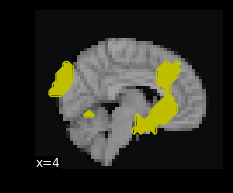

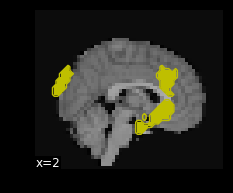

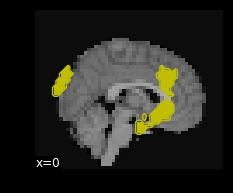

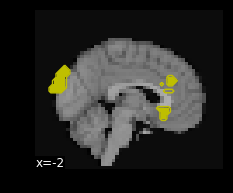

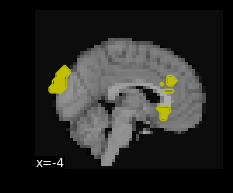

In [138]:
cut_it = list(range(-4, 52, 2))[::-1]

for i in cut_it:

    display = ni_plt.plot_anat(sub_nii, display_mode='x', cut_coords=[i])
    display.add_contours(mask, levels=[.5], filled=True, colors='y')